Instructions: click restart and run all above. Figures will show once the entire notebook has finished running

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import glob
from membranequant.funcs import direcslist
%matplotlib notebook

# The problem of autofluorescence

In green-channel images (laser: 488, filter: 535-50), embryos display a significant amount of autofluorescence. We can see a clear signal in images of N2 embryos, even though they contain no flourophore. It therefore follows that in any image that does contain a green fluorophore (e.g. NeonGreen::PAR-2 below, right), a significant component of the signal that we see will not be true flourophore signal, but autofluorescence. Therefore, in order to accurately quantify fluorophore-tagged protein distributions from these images, we must find a way to spatially remove this autofluorescence. 

<IPython.core.display.Javascript object>


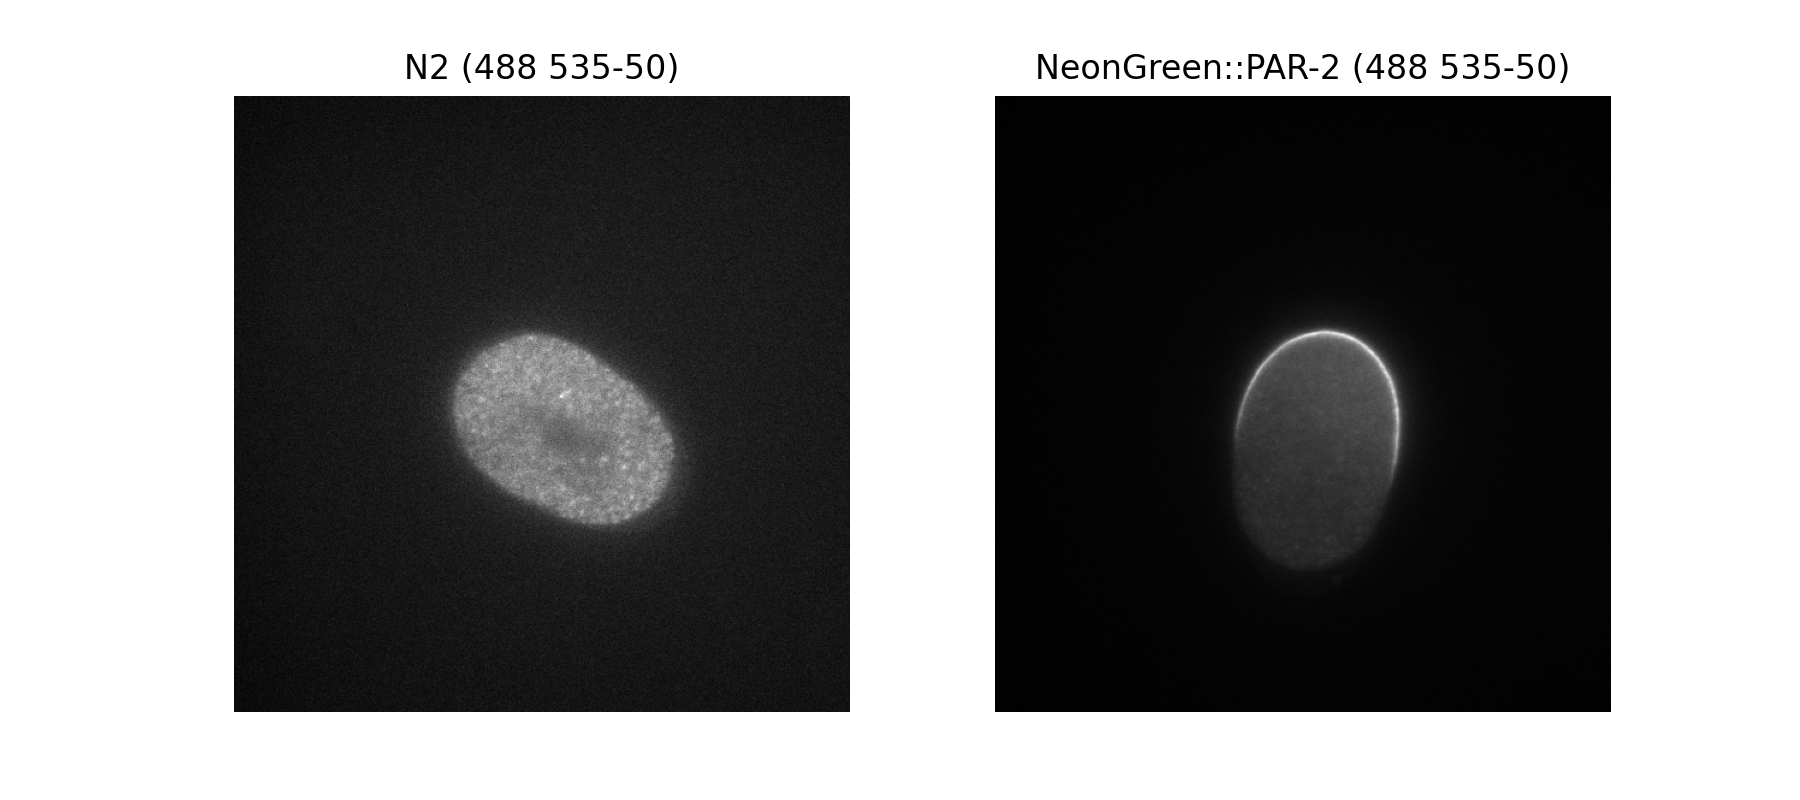

In [2]:
from membranequant.funcs import load_image

path_n2 = '../test_datasets/dataset1_n2/00/'
path_par2 = '../test_datasets/dataset2_par2_neon/00/'
ch1_n2 = load_image(glob.glob('%s/*488 SP 535-50*' % path_n2)[0])
ch1_par2 = load_image(glob.glob('%s/*488 SP 535-50*' % path_par2)[0])

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch1_n2, cmap='gray')
ax1.set_axis_off()
ax2.imshow(ch1_par2, cmap='gray')
ax2.set_axis_off()
ax1.set_title('N2 (488 535-50)')
ax2.set_title('NeonGreen::PAR-2 (488 535-50)')
fig.set_size_inches(9, 4)

# Autofluorescence reporter channel

The 535-50 filter used above is chosen to capture much of the NeonGreen signal, which has a relavitely narrow emission spectrum. By contrast, autofluorescence has a considerably wider emission spectrum. We can see below that by taking an image with the same laser, but a longer wavelength filter, we capture a very similar distribution of autofluorescence (N2 images are visually near identical between the two channels), but exclude much of the NeonGreen signal in the PAR-2 image. 

<IPython.core.display.Javascript object>


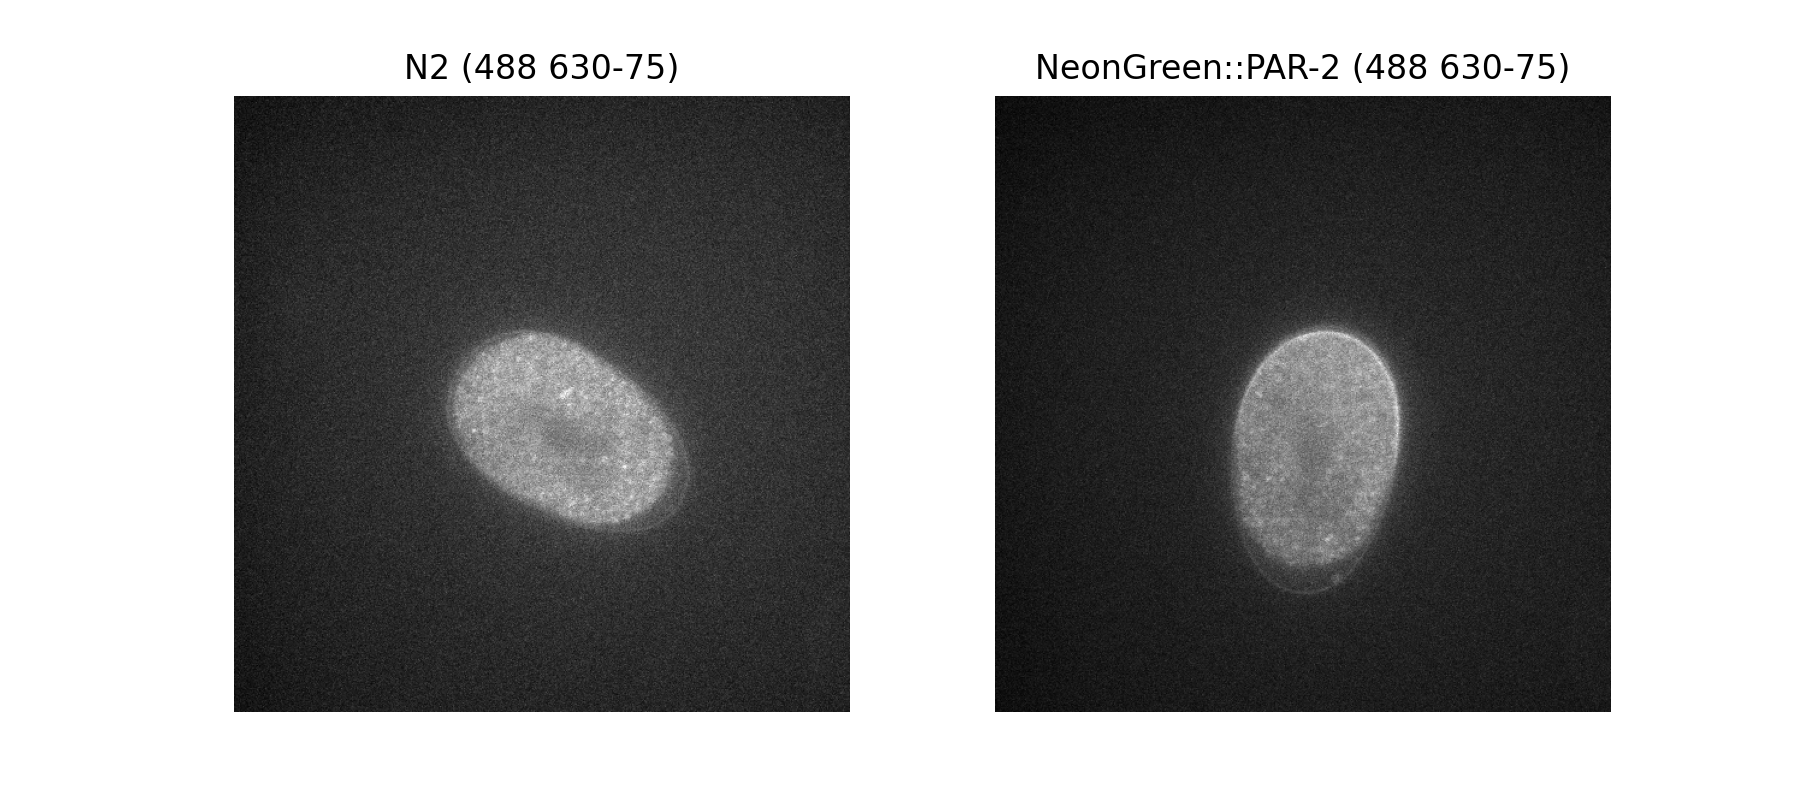

In [3]:
ch2_n2 = load_image(glob.glob('%s/*488 SP 630-75*' % path_n2)[0])
ch2_par2 = load_image(glob.glob('%s/*488 SP 630-75*' % path_par2)[0])

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch2_n2, cmap='gray')
ax2.imshow(ch2_par2, cmap='gray')
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('N2 (488 630-75)')
ax2.set_title('NeonGreen::PAR-2 (488 630-75)')
fig.set_size_inches(9, 4)

As a result, we can use this channel as an independent autofluorescence-reporter channel - i.e. we can use this channel to predict the autofluorescence contribution in our green channel images, and subtract it out. In order to do this, we need to perform a calibration on our N2 image, to obtain a quantitative correlation between the pixel intensities in the two channels.

# Pixel by pixel regression

The aim here is to perform a linear regression on the pixel intensities between the two channels of our N2 image. We will limit this to pixels within the embryo itself, and a small number of pixels surrounding the embryo (to account for background signal).

### Specify ROI

Specify a rough ROI containing the embryo. We can use the def_roi function to define this manually (a new interactive window will open), or load an ROI that's been pre-defined and saved as a txt file. See [here](./appendix_rois_and_straightening.ipynb)

In [4]:
# from membranequant.roi import def_roi
# %matplotlib tk
# roi = def_roi(ch1, spline=True, periodic=True)
# %matplotlib inline

roi = np.loadtxt(path_n2 + '/ROI.txt')

### Mask images

Using the specified ROI, we can mask the original images. Pixels outside of this region will be set to NaN, and will not be included in the regression. In order to include some of the background of the image, it is helpful to expand the ROI by ~10 pixels, which is easily achieved using the offset_coordinates function.

<IPython.core.display.Javascript object>


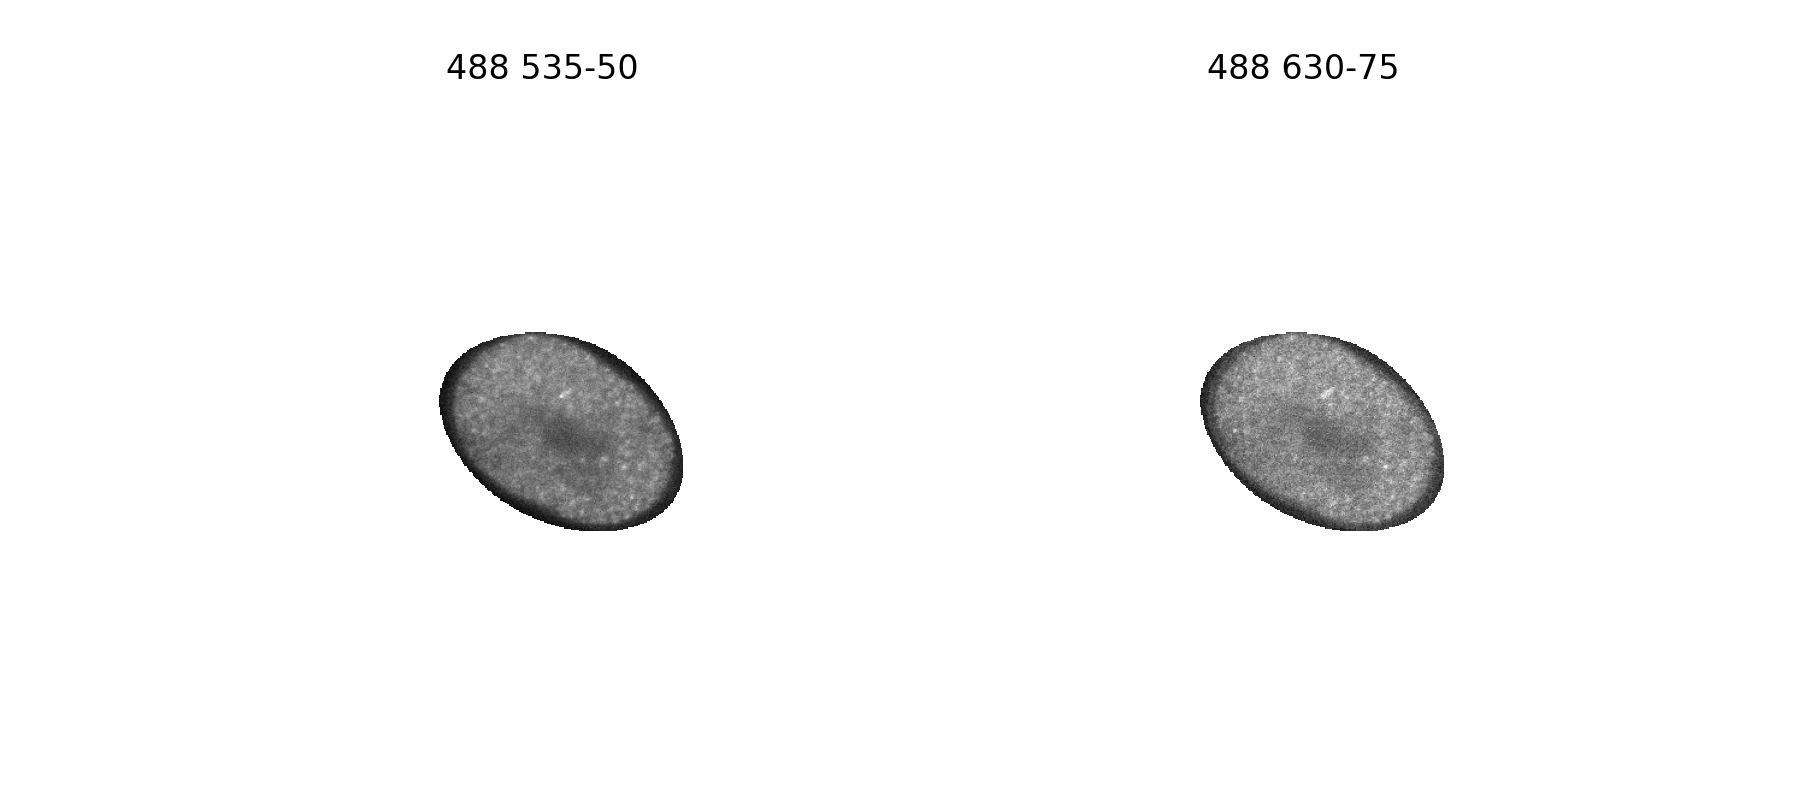

In [5]:
from membranequant.funcs import offset_coordinates
from membranequant.autofluorescence import make_mask

expand = 10
roi_expanded = offset_coordinates(roi, expand)
mask = make_mask(shape=ch1_n2.shape, roi=roi_expanded)
ch1_masked = ch1_n2 * mask
ch2_masked = ch2_n2 * mask

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ch1_masked, cmap='gray')
ax1.set_axis_off()
ax2.imshow(ch2_masked, cmap='gray')
ax2.set_axis_off()
ax1.set_title('488 535-50')
ax2.set_title('488 630-75')
fig.set_size_inches(9, 4)

### Perform linear regression

Performing a linear regression on the inter-channel pixel intensities, we see a clear positive correlation.

Note: we use orthogonal distance regression as there is measurement error in both the dependent and independent variables.

In [6]:
from scipy.optimize import curve_fit
import scipy.odr as odr

def get_correlation(ch1_masked, ch2_masked):
    # Flatten
    xdata = ch2_masked.flatten()
    ydata = ch1_masked.flatten()

    # Remove nans (masked regions)
    xdata = xdata[~np.isnan(xdata)]
    ydata = ydata[~np.isnan(ydata)]
    
    # Perform orthogonal distance regression
    odr_mod = odr.Model(lambda B, x: B[0] * x + B[1])
    odr_data = odr.Data(xdata, ydata)
    odr_odr = odr.ODR(odr_data, odr_mod, beta0=[1, 0])
    output = odr_odr.run()
    gradient, intercept = output.beta
    
    return gradient, intercept, xdata, ydata

gradient, intercept, xdata, ydata = get_correlation(ch1_masked, ch2_masked)
print('Gradient = %s' % gradient)
print('Intercept = %s' % intercept)

Gradient = 2.2159311482320985
Intercept = -2246.843334778971


<IPython.core.display.Javascript object>


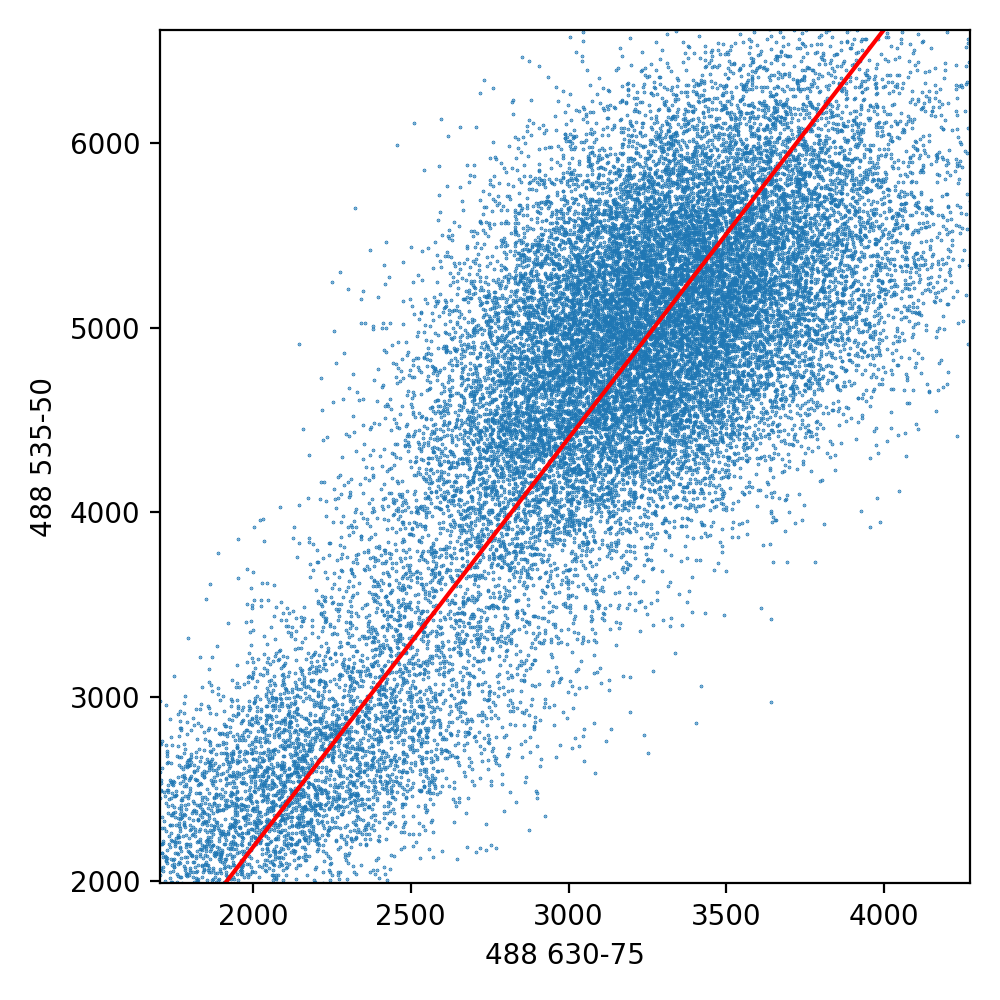

In [7]:
fig, ax = plt.subplots()
ax.scatter(xdata, ydata, s=0.1)
xline = np.linspace(np.percentile(xdata, 0.01), np.percentile(xdata, 99.99), 20)
yline = gradient * xline + intercept
ax.plot(xline, yline, c='r')
ax.set_xlim(np.percentile(xdata, 1), np.percentile(xdata, 99))
ax.set_ylim(np.percentile(ydata, 1), np.percentile(ydata, 99))
ax.set_xlabel('488 630-75')
ax.set_ylabel('488 535-50')
fig.set_size_inches(5, 5)
fig.tight_layout()

### Gaussian blur

We can see a clear positive trend, but the relationship is heavily dominated by noise. We can partially alleviate this by applying a Gaussian filter to our images, which removes much of the noise component whilst maintaing much of the spatial variation.

A narrow Gaussian (sigma ~1) is usually sufficient for this.

<IPython.core.display.Javascript object>


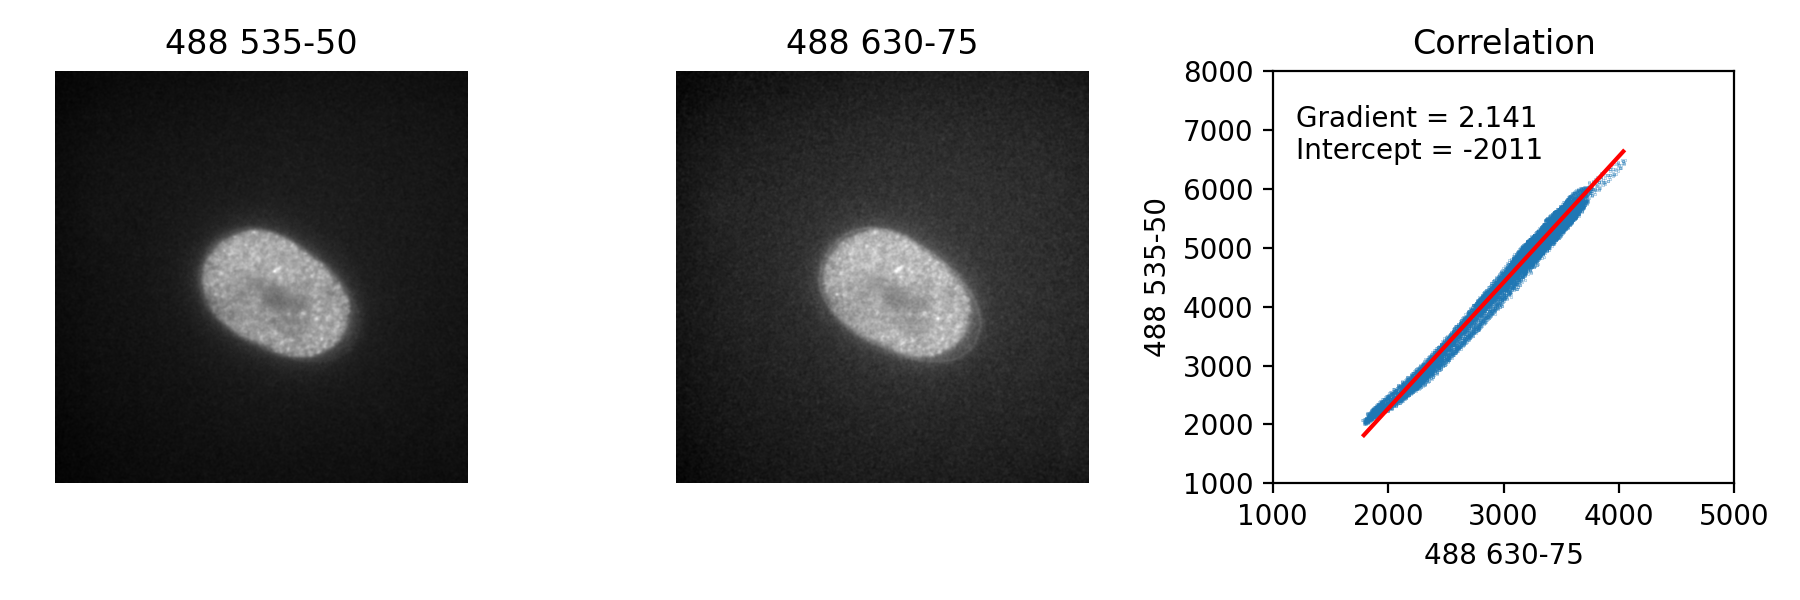

interactive(children=(FloatSlider(value=1.0, description='sigma', max=3.0, step=0.2), Output()), _dom_classes=…

In [8]:
from scipy.ndimage.filters import gaussian_filter
import ipywidgets as widgets

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
@widgets.interact(sigma=(0, 3, 0.2))
def update(sigma=1): 
    
    # Process data
    ch1_filtered = gaussian_filter(ch1_n2, sigma=sigma)
    ch2_filtered = gaussian_filter(ch2_n2, sigma=sigma)
    ch1_filtered_masked = ch1_filtered * mask
    ch2_filtered_masked = ch2_filtered * mask
    
    # Fig1
    ax1.clear()
    ax1.set_title('488 535-50')
    ax1.imshow(ch1_filtered, cmap='gray')
    ax1.set_axis_off()

    # Fig2
    ax2.clear()
    ax2.set_title('488 630-75')
    ax2.imshow(ch2_filtered, cmap='gray')
    ax2.set_axis_off()

    # Fig3 - correlation
    ax3.clear()
    ax3.set_title('Correlation')
    gradient, intercept, xdata, ydata = get_correlation(ch1_filtered_masked, ch2_filtered_masked)
    ax3.scatter(xdata, ydata, s=0.01)
    xline = np.linspace(np.percentile(xdata, 0.01), np.percentile(xdata, 99.99), 20)
    yline = gradient * xline + intercept
    ax3.plot(xline, yline, c='r')
    ax3.set_xlim(1000, 5000)
    ax3.set_ylim(1000, 8000)
    ax3.set_xlabel('488 630-75')
    ax3.set_ylabel('488 535-50')
    ax3.text(x=1200, y=6500, s='Gradient = %.3f\nIntercept = %i' % (gradient, intercept))
    # print('Gradient = %s' % gradient2)
    # print('Intercept = %s' % intercept2)
    
fig.set_size_inches(9,3)
fig.tight_layout()

We can see a much cleaner correlation, and the fitted line accurately depicts this relationship

# AfCorrelation class

The package provides a dedicated class to perform these operations quickly and easily: AfCorrelation. As seen below, the class takes a list of paths and regular expressions in order to import the relevant data for the regression. sigma (Gaussian blur parameter) and expand (ROI expansion parameter) are taken as arguments. Importantly, the class permits the use of many embryos in the same correlation (a list of multiple paths). Here we will pool pixel values from images of 4 different embryos. The class will also accept a third channel (ch3_regex) if available, which can act as a second predictive channel, and can improve fits in some cases.

In [9]:
from membranequant.autofluorescence import AfCorrelation

path = '../test_datasets/dataset1_n2/'
paths = direcslist(path, 0)
ch1_regex = '*488 SP 535-50*'
ch2_regex = '*488 SP 630-75*'
roi_regex = '*ROI*'

# Set up class
af = AfCorrelation(paths=paths, ch1_regex=ch1_regex, ch2_regex=ch2_regex, roi_regex=roi_regex, sigma=1, expand=10)

# Print parameters
print(af.params)

[    2.13062451 -1992.40495064]


<IPython.core.display.Javascript object>


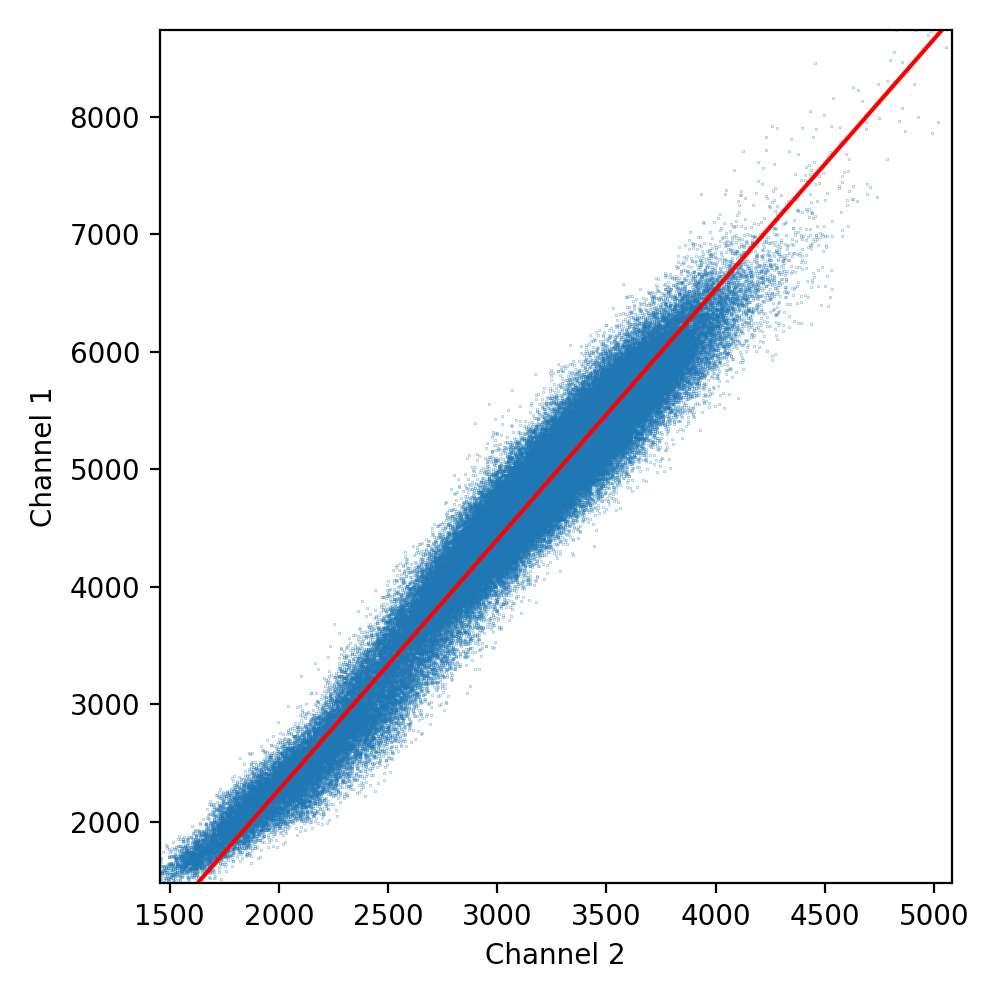

In [10]:
af.plot_correlation(s=0.01)
plt.gcf().set_size_inches(5,5)
plt.gcf().tight_layout()

# Autofluorescence subtraction

Once we have this relationship, we can use the autofluorescence channel to predict the autofluorescence signal in our green channel image on a pixel-by-pixel basis, and subtract this out to get a measure of the true fluorophore signal. We can do this using the af_subtration function, which takes images of two channels, and the parameters derived from the linear regression above, to return a single autofluorescence subtracted image.

In [11]:
from membranequant.autofluorescence import af_subtraction

### Example 1 - N2

As a negative control, performing this on an N2 image leaves a noisy image centred ~0, confirming a lack of fluorophore signal.

<IPython.core.display.Javascript object>


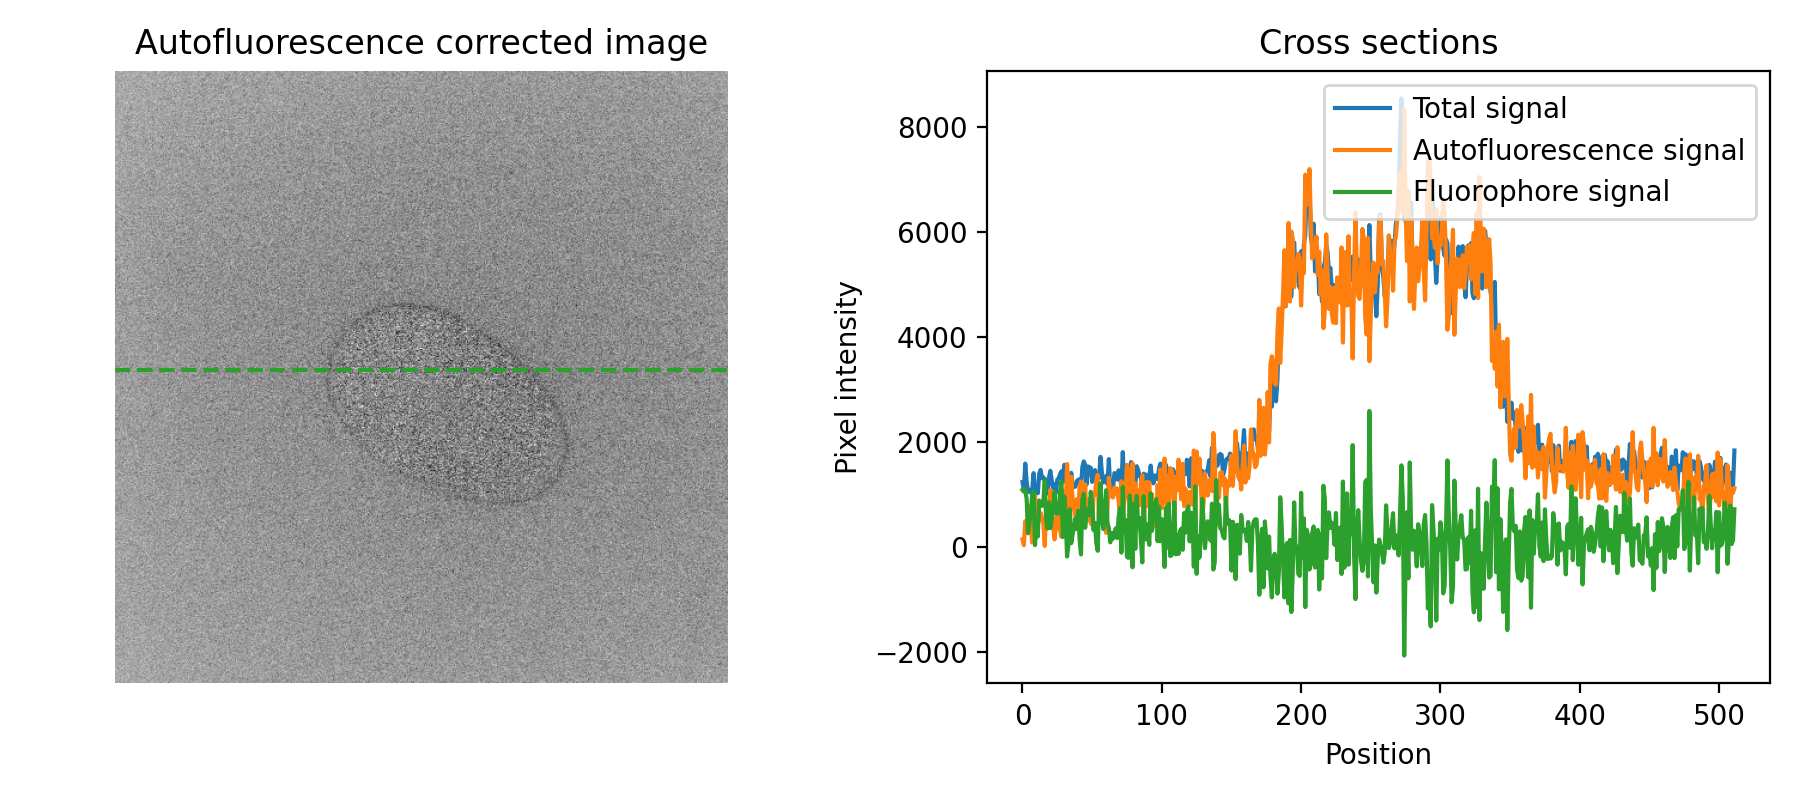

In [12]:
af_corrected_n2 = af_subtraction(ch1_n2, ch2_n2, *af.params)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(af_corrected_n2, cmap='gray')
ax1.set_title('Autofluorescence corrected image')
ax1.axhline(250, c='tab:green', linestyle='--')
ax1.set_axis_off()
ax2.plot(ch1_n2[250, :], label='Total signal')
ax2.plot(ch2_n2[250, :] * af.params[0] + af.params[1], label='Autofluorescence signal')
ax2.plot(af_corrected_n2[250, :], label='Fluorophore signal')
ax2.set_title('Cross sections')
ax2.set_xlabel('Position')
ax2.set_ylabel('Pixel intensity')
ax2.legend()
fig.set_size_inches(9,4)
fig.tight_layout()

### Example 2 - PAR-2

With a PAR-2 image, however, we see a significant fluorophore signal. This autofluorescence-corrected image can now be used for further analysis.

<IPython.core.display.Javascript object>


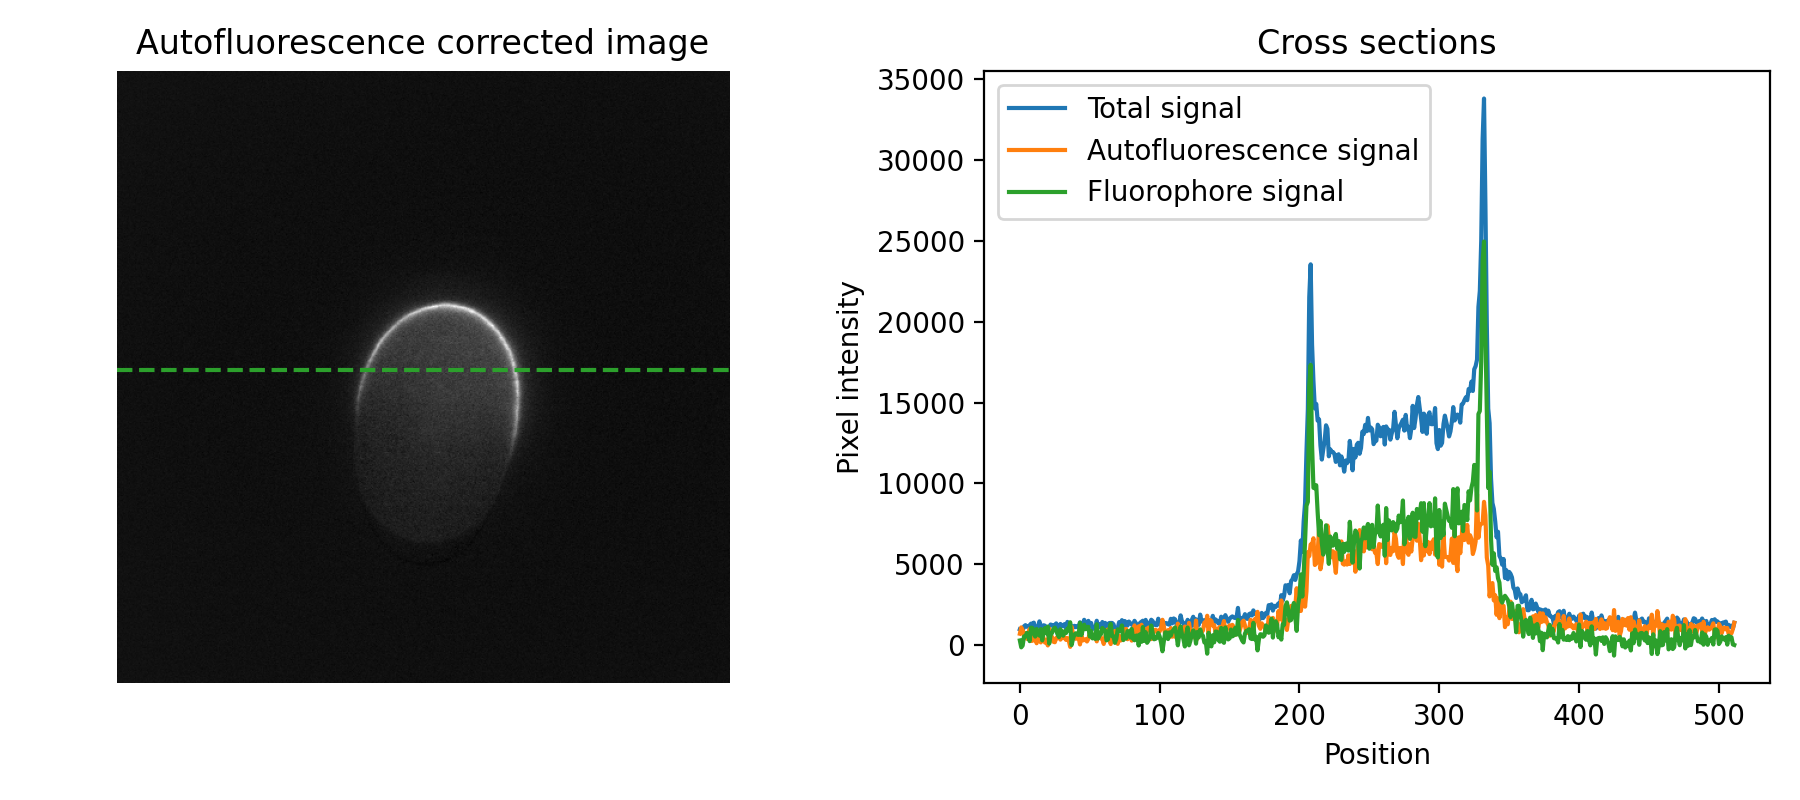

In [15]:
af_corrected_par2 = af_subtraction(ch1_par2, ch2_par2, *af.params)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(af_corrected_par2, cmap='gray')
ax1.set_title('Autofluorescence corrected image')
ax1.axhline(250, c='tab:green', linestyle='--')
ax1.set_axis_off()
ax2.plot(ch1_par2[250, :], label='Total signal')
ax2.plot(ch2_par2[250, :] * af.params[0] + af.params[1], label='Autofluorescence signal')
ax2.plot(af_corrected_par2[250, :], label='Fluorophore signal')
ax2.set_title('Cross sections')
ax2.set_xlabel('Position')
ax2.set_ylabel('Pixel intensity')
ax2.legend()
fig.set_size_inches(9,4)
fig.tight_layout()

(NB. As shown earlier, a small amount of fluorophore signal can bleed through into the autofluorescence reporter channel. This will end up being subtracted from the green channel image when we perform the autofluorescence correction. This is not a problem though, as this bleedthrough will be proportional to the true signal, and thus the signal in the autofluorescence-corrected image will still be in proportion to the true fluorophore signal.)

### Perform autofluorescence correction on test datasets

In [14]:
# from membranequant.autofluorescence import af_subtraction_3channel
# from membranequant.funcs import save_img
# 
# for path in direcslist('../test_datasets/dataset2_par2_neon/'):
#     ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
#     ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])
#     af_corrected = af_subtraction(ch1, ch2, *af.params)
#     save_img(af_corrected, '%s/af_corrected.tif' % path)
# 
# for path in direcslist('../test_datasets/dataset1_n2/'):
#     ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
#     ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])
#     af_corrected = af_subtraction(ch1, ch2, *af.params)
#     save_img(af_corrected, '%s/af_corrected.tif' % path)

# for path in direcslist('../test_datasets/dataset4_par2_c56s/'):  
#     ch1 = load_image(glob.glob('%s/*488 SP 535-50*' % path)[0])
#     ch2 = load_image(glob.glob('%s/*488 SP 630-75*' % path)[0])
#     ch3 = load_image(glob.glob('%s/*561 SP 630-75*' % path)[0])
#     af_corrected = af_subtraction_3channel(ch1, ch2, ch3, m1=2.09533494, m2=-0.92756335, c=365.8143061)
#     save_img(af_corrected, '%s/af_corrected.tif' % path)